In [31]:
# Standard libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.linear_model import RidgeClassifier, LogisticRegression

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.signals import zscore, resample
from mesostat.utils.pandas_helper import pd_query, pd_is_one_row
from mesostat.visualization.mpl_colorbar import imshow_add_color_bar
from mesostat.stat.classification import binary_classifier

from lib.sych.data_fc_db_raw import DataFCDatabase
from lib.sych.preprocess_raw import poly_fit_transform

from scipy.stats import mannwhitneyu

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO:
* Fit slow background to get rid of drift
* Fast background
    * Test if there exists variation on the order of 10-20 trials
    * Fit and extract
* Testing
    - Calc average activity over pre-trial, tex and reward (and maybe fast baseline)
    - Train classifier for trial type
    - Test
    - Try tSNE + color

In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
# params['root_path_data'] = gui_fpath('h5path', './')

In [3]:
dataDB = DataFCDatabase(params)

Searching for data files
Extracting trial type names
Extracting data types


In [4]:
sessions = dataDB.get_sessions('mvg_4')

In [5]:
dataThis, tiThis, itiThis, fps, trialTypes = dataDB.get_data_raw(sessions[-1])

# Have a look at raw data with trials

<IPython.core.display.Javascript object>


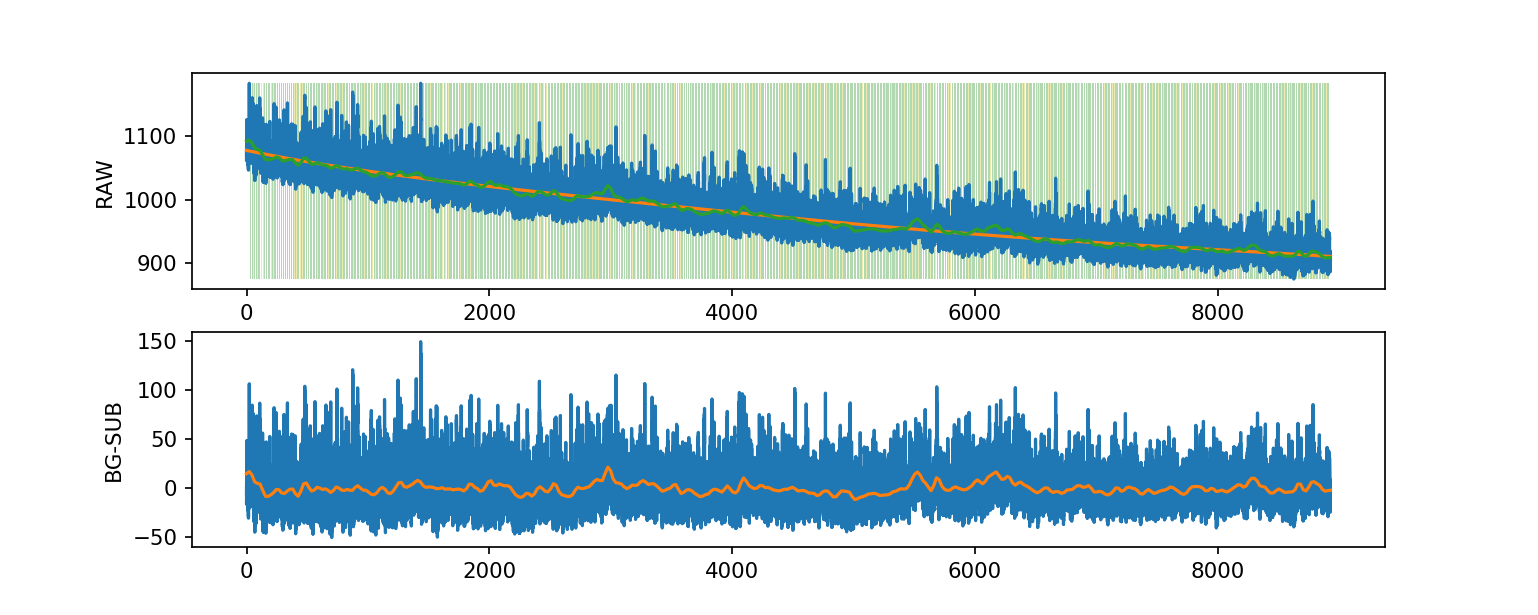

In [6]:
%matplotlib notebook
from matplotlib.collections import PatchCollection
import matplotlib

channelIdx = 0
dataThisCh = dataThis[:, channelIdx]

nTimePre = 2.0
nTimePost = 8.0
nTimeStep = len(dataThis)
times = np.arange(nTimeStep) / fps

yMin = np.min(dataThisCh)
yMax = np.max(dataThisCh)

# Trial boxes
patchesPre = []
patchesPost = []
for idx in tiThis:
    patchesPre += [matplotlib.patches.Rectangle((idx / fps - nTimePre, yMin), nTimePre, yMax-yMin)]
    patchesPost += [matplotlib.patches.Rectangle((idx / fps, yMin), nTimePost, yMax-yMin)]

# Background fitting
nPointRes = 400
paramRes = {'method' : 'kernel', 'kind':'gau', 'ker_sig2' : (times[-1] / nPointRes)**2}
tResampled = np.linspace(0, times[-1], nPointRes)
dataFitted = poly_fit_transform(times, dataThisCh, 5)
dataDiff = dataThisCh - dataFitted
dataResampled = resample(times, dataThisCh, tResampled, param=paramRes)
dataDiffResampled = resample(times, dataDiff, tResampled, param=paramRes)

fig, ax = plt.subplots(nrows=2, figsize=(10,4))
ax[0].plot(times, dataThisCh)
ax[0].plot(times, dataFitted)
ax[0].plot(tResampled, dataResampled)
ax[0].add_collection(PatchCollection(patchesPre, alpha=0.3, color='y', edgecolor='none'))
ax[0].add_collection(PatchCollection(patchesPost, alpha=0.3, color='g', edgecolor='none'))
ax[1].plot(times, dataDiff)
ax[1].plot(tResampled, dataDiffResampled)
ax[0].set_ylabel('RAW')
ax[1].set_ylabel('BG-SUB')
plt.show()

# Preparing data

In [14]:
trialTypesTrg = {'iGO', 'iNOGO'}
intervalsTrg = {
    'PRE' : [-1.0, 0.0],
    'TEX' : [3.0, 3.5],
    'REW' : [6.0, 6.5],
}

dataIndexed = []
dataDF = pd.DataFrame()
for mousename in dataDB.mice:
    for session in dataDB.get_sessions(mousename):
        dataThis, tiThis, itiThis, fps, trialTypes = dataDB.get_data_raw(session)
        for trialType in trialTypesTrg:
            trialIdxs = trialTypes == trialType
            nTrials = np.sum(trialIdxs)
            if nTrials < 50:
                print('Too few trials =', nTrials, ' for', session, trialType, ': skipping')
            else:
                tiTrials = tiThis[trialIdxs]

                for intervName, intervRng in intervalsTrg.items():
                    dataInterv = []
                    for idx in tiTrials:
                        idxL = int(idx + intervRng[0] * fps)
                        idxR = int(idx + intervRng[1] * fps + 1)
                        dataInterv += [np.mean(dataThis[idxL:idxR, :48], axis=0)]

                    dataIndexed += [np.array(dataInterv)]
                    dataDF = dataDF.append({'mousename':mousename, 'session':session,
                                            'trialType':trialType, 'interval':intervName}, ignore_index=True)

Too few trials = 39  for mvg_9_2019_02_06_a iGO : skipping
Too few trials = 23  for mvg_9_2019_02_06_a iNOGO : skipping
Too few trials = 15  for mvg_9_2019_02_08_a iGO : skipping
Too few trials = 5  for mvg_9_2019_02_08_a iNOGO : skipping
Too few trials = 16  for mvg_9_2019_02_12_a iGO : skipping
Too few trials = 35  for mvg_9_2019_02_12_a iNOGO : skipping
Too few trials = 44  for mvg_8_2018_11_12_a iGO : skipping
Too few trials = 11  for mvg_8_2018_11_12_a iNOGO : skipping
Too few trials = 41  for mvg_8_2018_11_13_a iGO : skipping
Too few trials = 4  for mvg_8_2018_11_13_a iNOGO : skipping
Too few trials = 30  for mvg_8_2018_11_14_a iNOGO : skipping
Too few trials = 38  for mvg_8_2018_11_18_a iGO : skipping
Too few trials = 21  for mvg_8_2018_11_18_a iNOGO : skipping
Too few trials = 3  for mvg_7_2018_11_09_a iGO : skipping
Too few trials = 0  for mvg_7_2018_11_09_a iNOGO : skipping
Too few trials = 13  for mvg_7_2018_11_12_a iGO : skipping
Too few trials = 0  for mvg_7_2018_11_12_a i

# Exploratory Testing
* Test if GO vs NOGO significant for each session and channel

PRE mvg_4_2017_11_10_a
PRE mvg_4_2017_11_13_a
PRE mvg_4_2017_11_14_a
PRE mvg_4_2017_11_15_a
PRE mvg_4_2017_11_16_a
PRE mvg_4_2017_11_17_a
PRE mvg_4_2017_11_20_a
PRE mvg_4_2017_11_21_a
PRE mvg_4_2017_11_22_a
PRE mvg_4_2017_11_23_a
PRE mvg_4_2017_11_24_a
TEX mvg_4_2017_11_10_a
TEX mvg_4_2017_11_13_a
TEX mvg_4_2017_11_14_a
TEX mvg_4_2017_11_15_a
TEX mvg_4_2017_11_16_a
TEX mvg_4_2017_11_17_a
TEX mvg_4_2017_11_20_a
TEX mvg_4_2017_11_21_a
TEX mvg_4_2017_11_22_a
TEX mvg_4_2017_11_23_a
TEX mvg_4_2017_11_24_a
REW mvg_4_2017_11_10_a
REW mvg_4_2017_11_13_a
REW mvg_4_2017_11_14_a
REW mvg_4_2017_11_15_a
REW mvg_4_2017_11_16_a
REW mvg_4_2017_11_17_a
REW mvg_4_2017_11_20_a
REW mvg_4_2017_11_21_a
REW mvg_4_2017_11_22_a
REW mvg_4_2017_11_23_a
REW mvg_4_2017_11_24_a


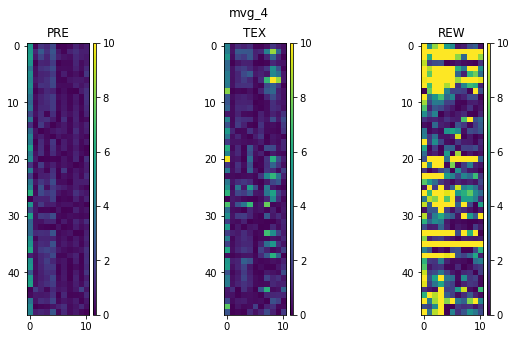

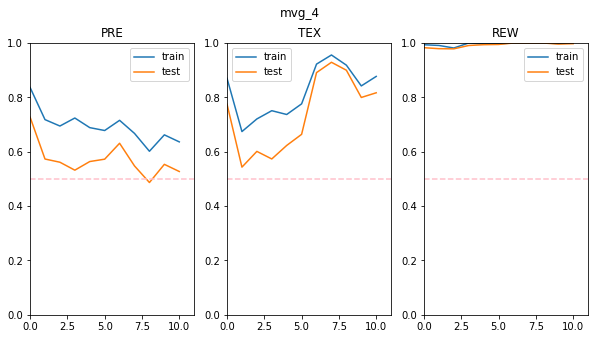

PRE mvg_7_2018_11_09_a
Skipping session mvg_7_2018_11_09_a because too few trials
PRE mvg_7_2018_11_12_a
Skipping session mvg_7_2018_11_12_a because too few trials
PRE mvg_7_2018_11_13_a
Skipping session mvg_7_2018_11_13_a because too few trials
PRE mvg_7_2018_11_14_a
Skipping session mvg_7_2018_11_14_a because too few trials
PRE mvg_7_2018_11_15_a
PRE mvg_7_2018_11_17_a
PRE mvg_7_2018_11_18_a
PRE mvg_7_2018_11_19_a
PRE mvg_7_2018_11_20_a
PRE mvg_7_2018_11_21_a
PRE mvg_7_2018_11_22_a
PRE mvg_7_2018_11_23_a
PRE mvg_7_2018_11_24_a
PRE mvg_7_2018_11_26_a
PRE mvg_7_2018_11_28_a
PRE mvg_7_2018_11_29_a
PRE mvg_7_2018_12_04_a
PRE mvg_7_2018_12_05_a
TEX mvg_7_2018_11_09_a
Skipping session mvg_7_2018_11_09_a because too few trials
TEX mvg_7_2018_11_12_a
Skipping session mvg_7_2018_11_12_a because too few trials
TEX mvg_7_2018_11_13_a
Skipping session mvg_7_2018_11_13_a because too few trials
TEX mvg_7_2018_11_14_a
Skipping session mvg_7_2018_11_14_a because too few trials
TEX mvg_7_2018_11_15_a

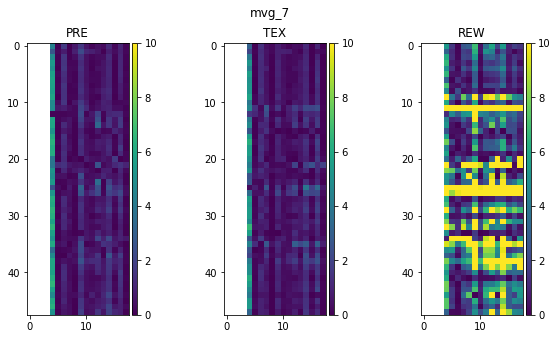

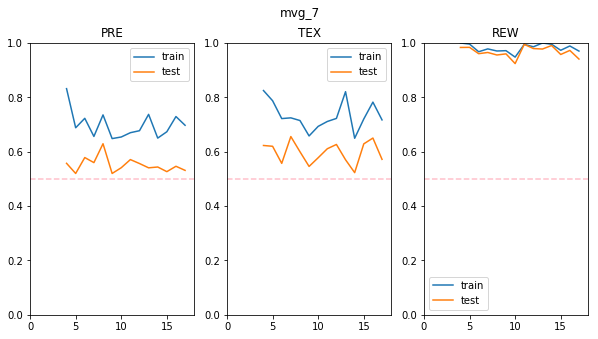

PRE mvg_8_2018_11_12_a
Skipping session mvg_8_2018_11_12_a because too few trials
PRE mvg_8_2018_11_13_a
Skipping session mvg_8_2018_11_13_a because too few trials
PRE mvg_8_2018_11_14_a
Skipping session mvg_8_2018_11_14_a because too few trials
PRE mvg_8_2018_11_15_a
PRE mvg_8_2018_11_16_a
PRE mvg_8_2018_11_17_a
PRE mvg_8_2018_11_18_a
Skipping session mvg_8_2018_11_18_a because too few trials
PRE mvg_8_2018_11_19_a
PRE mvg_8_2018_11_20_a
PRE mvg_8_2018_11_21_a
PRE mvg_8_2018_11_22_a
PRE mvg_8_2018_11_23_a
PRE mvg_8_2018_11_27_a
PRE mvg_8_2018_11_28_a
PRE mvg_8_2018_11_29_a
PRE mvg_8_2018_12_04_a
TEX mvg_8_2018_11_12_a
Skipping session mvg_8_2018_11_12_a because too few trials
TEX mvg_8_2018_11_13_a
Skipping session mvg_8_2018_11_13_a because too few trials
TEX mvg_8_2018_11_14_a
Skipping session mvg_8_2018_11_14_a because too few trials
TEX mvg_8_2018_11_15_a
TEX mvg_8_2018_11_16_a
TEX mvg_8_2018_11_17_a
TEX mvg_8_2018_11_18_a
Skipping session mvg_8_2018_11_18_a because too few trials

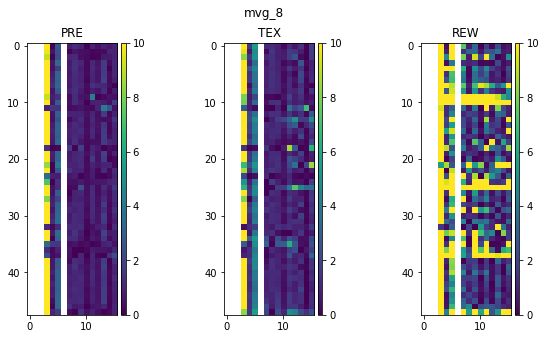

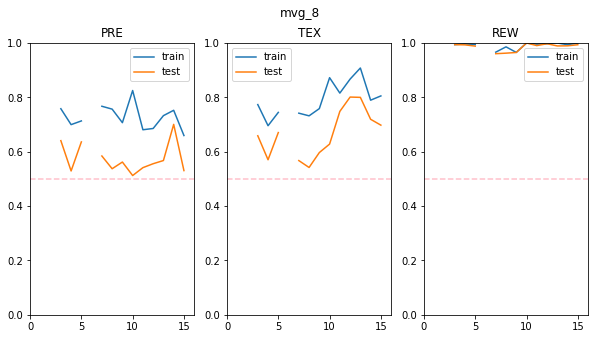

PRE mvg_9_2019_02_06_a
Skipping session mvg_9_2019_02_06_a because too few trials
PRE mvg_9_2019_02_07_a
PRE mvg_9_2019_02_08_a
Skipping session mvg_9_2019_02_08_a because too few trials
PRE mvg_9_2019_02_12_a
Skipping session mvg_9_2019_02_12_a because too few trials
PRE mvg_9_2019_02_13_a
PRE mvg_9_2019_02_14_a
PRE mvg_9_2019_02_18_a
PRE mvg_9_2019_02_19_a
PRE mvg_9_2019_02_20_a
PRE mvg_9_2019_02_21_a
PRE mvg_9_2019_02_23_a
PRE mvg_9_2019_02_24_a
PRE mvg_9_2019_02_25_a
PRE mvg_9_2019_02_26_a
PRE mvg_9_2019_02_27_a
PRE mvg_9_2019_03_04_a
PRE mvg_9_2019_03_05_a
PRE mvg_9_2019_03_06_a
PRE mvg_9_2019_03_07_a
PRE mvg_9_2019_03_08_a
PRE mvg_9_2019_03_09_a
TEX mvg_9_2019_02_06_a
Skipping session mvg_9_2019_02_06_a because too few trials
TEX mvg_9_2019_02_07_a
TEX mvg_9_2019_02_08_a
Skipping session mvg_9_2019_02_08_a because too few trials
TEX mvg_9_2019_02_12_a
Skipping session mvg_9_2019_02_12_a because too few trials
TEX mvg_9_2019_02_13_a
TEX mvg_9_2019_02_14_a
TEX mvg_9_2019_02_18_a
TE

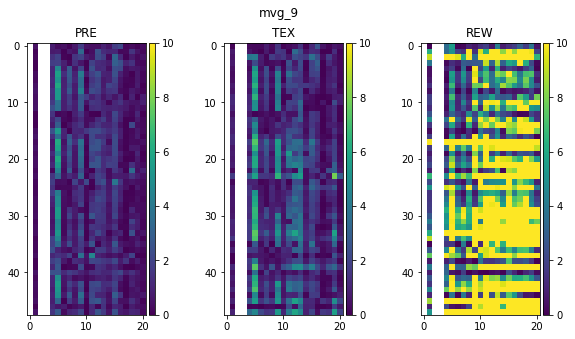

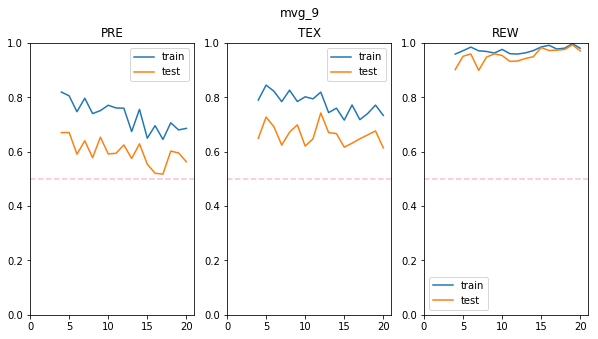

In [101]:
%matplotlib inline

# classifier = LogisticRegression(max_iter=10000, C=1.0E-2, solver='lbfgs')
classifier = RidgeClassifier(max_iter=10000, alpha=1.0E-2)

for mousename in sorted(dataDB.mice):
    sessions = dataDB.get_sessions(mousename)

    nSessions = len(sessions)
    nIntervals = len(intervalsTrg)

    figTest, axTest = plt.subplots(ncols=3, figsize=(10,5))
    figClass, axClass = plt.subplots(ncols=3, figsize=(10,5))
    figTest.suptitle(mousename)
    figClass.suptitle(mousename)

    for iInterv, (intervName, intervRng) in enumerate(intervalsTrg.items()):
        testMat = np.zeros((48, nSessions))
        accLst = []
        
        for iSession, session in enumerate(sessions):
            print(intervName, session)
            
            queryDict = {'mousename' : mousename, 'session':session, 'interval': intervName}
            rowGo = pd_query(dataDF, {**queryDict, **{'trialType' : 'iGO'}})
            rowNogo = pd_query(dataDF, {**queryDict, **{'trialType' : 'iNOGO'}})
            
            if (len(rowGo) == 0) or (len(rowNogo) == 0):
                print('Skipping session', session, 'because too few trials')
                testMat[:, iSession] = np.nan
                accLst += [{'accTrain' : np.nan, 'accTest' : np.nan}]
            else:
                idxRowGO, _ = pd_is_one_row(rowGo)
                idxRowNOGO, _ = pd_is_one_row(rowNogo)
                dataGO = dataIndexed[idxRowGO]
                dataNOGO = dataIndexed[idxRowNOGO]

                # Doing pairwise testing on individual channels
                for iCh in range(48):
                    p = mannwhitneyu(dataGO[:, iCh], dataNOGO[:, iCh], alternative='two-sided')[1]
                    testMat[iCh, iSession] = -np.log10(p)
                    
                # Doing classification
                accLst += [binary_classifier(dataGO, dataNOGO, classifier,
                                             method="looc", balancing=False)]

        # Plot test
        axTest[iInterv].set_title(intervName)
        img = axTest[iInterv].imshow(testMat, vmin=0, vmax=10)
        imshow_add_color_bar(figTest, axTest[iInterv], img)
        
        # Plot classification
        axClass[iInterv].set_title(intervName)
        axClass[iInterv].plot([l['accTrain'] for l in accLst], label='train')
        axClass[iInterv].plot([l['accTest'] for l in accLst], label='test')
        axClass[iInterv].axhline(y=0.5, linestyle='--', color='pink')
        axClass[iInterv].set_xlim(0, len(sessions))
        axClass[iInterv].set_ylim(0, 1)
        axClass[iInterv].legend()
        
    plt.show()

# Training a classifier
* Predict this trial
* Predict next trial

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
100000000.0
1000000000.0


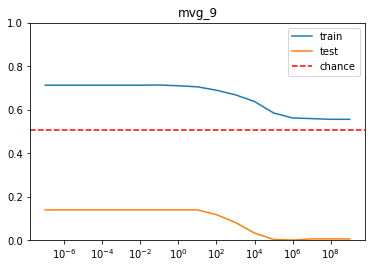

In [35]:
CLst = 10.0**np.arange(-7, 10)

rezLst = []
for C in CLst:
    print(C)
#     classifier = LogisticRegression(max_iter=10000, C=C, solver='lbfgs')
    classifier = RidgeClassifier(max_iter=10000, alpha=C)
    rezLst += [binary_classifier(dataGO, dataNOGO, classifier, havePVal=True, method='kfold')]

df = pd.DataFrame(rezLst)
#         display(df)

fig, ax = plt.subplots()
ax.set_title(mousename)
ax.semilogx(CLst, df['accTrain'], label='train')
ax.semilogx(CLst, df['accTest'], label='test')
ax.axhline(y=df['accNaive'][0], linestyle='--', color='r', label='chance')
ax.set_ylim([0,1])
ax.legend()
plt.show()